In [2]:
import numpy as np
import pandas as pd
import os

from tvb.simulator.lab import *
import sys
import scipy.io
import tvbsim

np.random.seed(123456789)

# plotting fxns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

   INFO  log level set to INFO


In [3]:
# set all directories
root_dir = os.path.join('/Users/adam2392/Documents/pydata/')

patient='id008_gc'
# patient ='id013_pg'
# patient = 'id001_ac'
# patient = 'id007_fo'
# patient = 'id009_il'
# patient = 'id010_js'
# patient = 'id012_pc'
# patient = 'id014_rb'
# patient = 'id015_sf'
expname = 'exp007'

metadatadir = os.path.join(root_dir, "metadata", patient)
outputdatadir = os.path.join('/Users/adam2392/Documents/pydata/tvbforwardsim/', expname)
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)

tvbsim.util.renamefiles(patient, metadatadir)

# get the important files
getfilepath = lambda filename: os.path.join(metadatadir, filename)
seegfile = getfilepath('seeg.txt')
gainfile = getfilepath('gain_inv-square.txt')
# surffile = getfilepath

Already renamed seeg.xyz possibly!


In [4]:
''' THE REAL CLINICALLY ANNOTATED AREAS '''
#001
if 'id001' in patient:
    ezregions = ['ctx-rh-lateralorbitofrontal', 'ctx-rh-temporalpole']
    pzregions = ['ctx-rh-superiorfrontal', 'ctx-rh-rostralmiddlefrontal', 'ctx-lh-lateralorbitofrontal']
if 'id002' in patient:
    ezregions = ['ctx-lh-lateraloccipital']
    pzregions = ['ctx-lh-inferiorparietal', 'ctx-lh-superiorparietal']
if 'id003' in patient:
    ezregions = ['ctx-lh-insula']
    pzregions = ['Left-Putamen', 'ctx-lh-postcentral']
if 'id004' in patient: 
    ''' sup '''
    ezregions = ['ctx-lh-posteriorcingulate', 'ctx-lh-middlefrontal', 'ctx-lh-superiorfrontal']
    pzregions = ['ctx-lh-precentral', 'ctx-lh-postcentral']
if 'id005' in patient: # et
    ''' '''
    ezregions = ['ctx-lh-posteriorcingulate', 'ctx-lh-precuneus']
    pzregions = ['ctx-lh-postcentral', 'ctx-lh-superiorparietal']
if 'id006' in patient: # fb
    ''' '''
    ezregions = ['ctx-rh-precentral']
    pzregions = ['ctx-rh-postcentral', 'ctx-rh-superiorparietal']
if 'id007' in patient: 
    ''' '''
    ezregions = ['Right-Amygdala', 'ctx-rh-temporalpole', 'ctx-rh-lateralorbitofrontal']
    pzregions = ['Right-Hippocampus', 'ctx-rh-entorhinal', 'ctx-rh-medialorbitofrontal',
                 'ctx-rh-inferiortemporal', 'ctx-rh-temporalpole', 'ctx-rh-lateralorbitofrontal']
if 'id009' in patient:
    ezregions = ['ctx-rh-lingual', 'ctx-rh-parahippocampal']
    pzregions = ['ctx-rh-lateraloccipital', 'ctx-rh-fusiform', 'ctx-rh-inferiorparietal'] # rlocc, rfug, ripc
if 'id010' in patient:
    ezregions = ['ctx-rh-medialorbitofrontal', 'ctx-rh-frontalpole', 'ctx-rh-rostralmiddlefrontal', 'ctx-rh-parsorbitalis'] #  rmofc, rfp, rrmfg, rpor   
    pzregions = ['ctx-rh-lateralorbitofrontal', 'ctx-rh-rostralmiddlefrontal',
                 'ctx-rh-superiorfrontal', 'ctx-rh-caudalmiddlefrontal'] # rlofc, rrmfc, rsfc, rcmfg
if 'id011' in patient: # id011_ml
    ezregions = ['Right-Hippocampus', 'Right-Amygdala'] # rhi, ramg
    pzregions = ['Right-Thalamus-Proper', 'Right-Caudate', 'Right-Putamen',
                 'ctx-rh-insula', 'ctx-rh-entorhinal', 'ctx-rh-temporalpole'] # rth, rcd, rpu, rins, rentc, rtmp
if 'id012' in patient:
    ezregions = ['Right-Hippocampus', 'ctx-rh-fusiform', 'ctx-rh-entorhinal', 'ctx-rh-temporalpole'] # rhi, rfug, rentc, rtmp
    pzregions = ['ctx-lh-fusiform', 'ctx-rh-inferiorparietal', 'ctx-rh-inferiortemporal',
                 'ctx-rh-lateraloccipital', 'ctx-rh-parahippocampal', 'ctx-rh-precuneus', 'ctx-rh-supramarginal'] # lfug, ripc, ritg, rloc, rphig, rpcunc, rsmg
# 014
if 'id014' in patient:
    ezregions = ['Left-Amygdala', 'Left-Hippocampus', 'ctx-lh-entorhinal', 'ctx-lh-fusiform',
         'ctx-lh-temporalpole','ctx-rh-entorhinal']
    pzregions = ['ctx-lh-superiortemporal', 'ctx-lh-middletemporal', 'ctx-lh-inferiortemporal',
         'ctx-lh-insula', 'ctx-lh-parahippocampal']
# if 'id015' in patient:
#     ezregions = ['ctx-rh-lingual', 'ctx-rh-lateraloccipital', 'ctx-rh-cuneus',
#                     'ctx-rh-parahippocampal', 'ctx-rh-superiorparietal', 'ctx-rh-fusiform', 'ctx-rh-pericalcarine'] # rlgg, rloc, rcun, rphig, rspc, rfug, rpc
#     pzregions = ['ctx-rh-parahippocampal', 'ctx-rh-superiorparietal', 'ctx-rh-fusiform'] # rphig, rspc, rfug
    
# 008
if 'id008' in patient:
    ezregions = ['Right-Amygdala', 'Right-Hippocampus']
#     ezregions = ['ctx-rh-frontalpole'] # fake (region 80)
#     ezregions = ['ctx-rh-middletemporal', 'Right-Hippocampus'] # fake (region 62)
#     ezregions = ['ctx-rh-middletemporal', 'Right-Hippocampus'] # fake 62andhippo

#     ezregions = ['ctx-rh-rostralmiddlefrontal', 'Right-Hippocampus'] # to cover the region around cr and r electrodes
#     pzregions = ['ctx-rh-superiortemporal']
    pzregions = ['ctx-rh-superiortemporal', 'ctx-rh-temporalpole', 'ctx-rh-inferiortemporal',
     'ctx-rh-medialorbitofrontal', 'ctx-rh-lateralorbitofrontal']

# 013
if 'id013' in patient:
    ezregions = ['ctx-rh-fusiform']
#     ezregions = ['ctx-rh-frontalpole'] # fake (region 80)
#     ezregions = ['ctx-rh-temporalpole'] # fake (regions 81)
#     pzregions = ['Right-Hippocampus']
    pzregions = ['ctx-rh-inferiortemporal','Right-Hippocampus','Right-Amygdala', 
          'ctx-rh-middletemporal','ctx-rh-entorhinal']

In [5]:
# initialize structural connectivity and main simulator object
con = connectivity.Connectivity.from_file(os.path.join(metadatadir, "connectivity.zip"))
maintvbexp = tvbsim.MainTVBSim(con, condspeed=np.inf)
# load the necessary data files to run simulation
maintvbexp.loadseegxyz(seegfile=seegfile)
maintvbexp.loadgainmat(gainfile=gainfile)
maintvbexp.loadsurfdata(directory=metadatadir, use_subcort=False)

# set ez/pz regions
# pzregions = []
# ezregions = []
maintvbexp.setezregion(ezregions=ezregions)
maintvbexp.setpzregion(pzregions=pzregions)
print(maintvbexp.ezind)
print(maintvbexp.ezregion)
print(maintvbexp.pzregion)
print(maintvbexp.conn.speed)

WARNING  File 'hemispheres' not found in ZIP.
NOT USING SUBCORT
[47 46]
['Right-Amygdala' 'Right-Hippocampus']
['ctx-rh-superiortemporal' 'ctx-rh-temporalpole' 'ctx-rh-inferiortemporal'
 'ctx-rh-medialorbitofrontal' 'ctx-rh-lateralorbitofrontal']
[inf]


In [6]:
# print(maintvbexp.conn.region_labels)
print(maintvbexp.conn.region_labels[80])
# 'Right-Hippocampus','Right-Amygdala', 
#           'ctx-rh-middletemporal','ctx-rh-entorhinal'
# print(np.where(maintvbexp.conn.region_labels == 'Right-Hippocampus'))
print(np.where(maintvbexp.conn.region_labels == 'ctx-rh-rostralmiddlefrontal'))

ctx-rh-temporalpole
(array([74]),)


In [7]:
# setup models and integrators
######### Epileptor Parameters ##########
# epileptor_r = 0.00035        # Temporal scaling in the third state variable
# epiks = -10                  # Permittivity coupling, fast to slow time scale
# epitt = 0.07                   # time scale of simulation
# epitau = 10                 # Temporal scaling coefficient in fifth st var
# x0norm=-2.35 # x0c value = -2.05
# x0ez=-1.65
# x0pz=-2.0
# if maintvbexp.ezregion is None:
#     x0ez = None
# if maintvbexp.pzregion is None:
#     x0pz = None
    
######### Epileptor Parameters ##########
epileptor_r = 0.00037        # Temporal scaling in the third state variable
epiks = -10                  # Permittivity coupling, fast to slow time scale
epitt = 0.05                   # time scale of simulation
epitau = 10                   # Temporal scaling coefficient in fifth st var
x0norm=-2.45 # x0c value = -2.05
x0ez=-1.85 # -1.8
x0pz=-2.0 # -1.925
# x0pz = None

if maintvbexp.ezregion is None:
    x0ez = None
if maintvbexp.pzregion is None:
    x0pz = None    
    
######### Integrator Parameters ##########
# parameters for heun-stochastic integrator
heun_ts = 0.05
noise_cov = np.array([0.001, 0.001, 0.,\
                      0.0001, 0.0001, 0.])*1.
ntau = 0
# noise_cov = np.array([1.001, 1.001, 0.,\
#                       1.0001, 1.0001, 0.])*1.2
# simulation parameters
_factor = 1
_samplerate = 1000*_factor # Hz
sim_length = 60*_samplerate    
period = 1./_factor

maintvbexp.initepileptor(x0norm=x0norm, x0ez=x0ez, x0pz=x0pz,
                        r=epileptor_r, Ks=epiks, tt=epitt, tau=epitau)
maintvbexp.initintegrator(ts=heun_ts, noise_cov=noise_cov, ntau=ntau)

In [8]:
dist = -1
for ind in maintvbexp.ezind:
    new_seeg_xyz, elecindicesmoved = maintvbexp.move_electrodetoreg(ind, dist)
print(elecindicesmoved)
print(maintvbexp.seeg_labels[elecindicesmoved])

maintvbexp._computeinitcond(-2.05, 84)

# simplegain = maintvbexp.simplest_gain_matrix()
# maintvbexp.gainmat = simplegain
# gainmat = maintvbexp.gain_matrix_inv_square()
# maintvbexp.gainmat = gainmat

print(maintvbexp.gainmat.shape)
print(x0ez)
print(x0pz)
print(maintvbexp.getepileptorparams())
# if dist < 1:
#     dist = 0

None
[['R1' 'R2' 'R3' 'R4' 'R5' 'R6' 'R7' 'R8' 'R9' 'R10' 'R11' 'CR1' 'CR2'
  'CR3' 'CR4' 'CR5' 'CR6' 'CR7' 'CR8' 'CR9' 'CR10' 'CR11' 'FD1' 'FD2'
  'FD3' 'FD4' 'FD5' 'FD6' 'FD7' 'FD8' 'FD9' 'FD10' 'FD11' 'CC1' 'CC2'
  'CC3' 'CC4' 'CC5' 'CC6' 'CC7' 'CC8' 'CC9' 'CC10' 'CC11' 'TP1' 'TP2'
  'TP3' 'TP4' 'TP5' 'TP6' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9'
  'A10' 'A11' 'A12' 'A13' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B9'
  'B10' 'B11' 'B12' 'B13' 'GPH1' 'GPH2' 'GPH3' 'GPH4' 'GPH5' 'GPH6'
  'GPH7' 'GPH8' 'GPH9' 'GPH10' 'GPH11' 'GPH12' 'T1' 'T2' 'T3' 'T4' 'OR1'
  'OR2' 'OR3' 'OR4' 'OR5' 'OR6' 'OR7' 'OR8' 'OR9' 'OR10' 'OR11']]
(103, 84)
-1.85
-2.0
{'ntau': 0, 'tau': array([10]), 'nsig': array([0.001 , 0.001 , 0.    , 0.0001, 0.0001, 0.    ]), 'tt': array([0.05]), 'ks': array([-10]), 'r': array([0.00037]), 'x0': array([-2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2

In [9]:
# print(maintvbexp.init_cond.shape)

# N = len(maintvbexp.conn.region_labels)
# x1_init = -1.6*np.ones((1,N) )
# x2_init = -1*np.ones((1,N))
# z_init = 3.8*np.ones((1,N))
# y1_init = -13*np.ones((1,N))
# y2_init = 0.002*np.ones((1,N))
# u_init =  -0.17*np.ones((1,N))

# initcond = np.concatenate((x1_init, x2_init, z_init, 
#                            y1_init, y2_init, u_init), axis=0)
# print(initcond.shape)
# initcond = initcond.reshape((1,initcond.shape[0], initcond.shape[1],1))
# print(initcond.shape)

In [10]:
# initcond = None
configs = maintvbexp.setupsim(a=1., period=period, moved=False)
display(configs)
times, epilepts, seegts = maintvbexp.mainsim(sim_length=sim_length)

na was less than one
na was less than one
na was less than one
na was less than one
na was less than one
na was less than one
na was less than one
na was less than one
na was less than one
na was less than one
na was less than one
na was less than one
na was less than one


initial_conditions,None
coupling,Difference(a=1)
stimulus,None
integrator,"HeunStochastic(dt=0.05, noise=Additive(dt=0.05, ntau=0))"
surface,None
connectivity,"Connectivity(bound=False, value=None)"
conduction_speed,3.0
simulation_length,1000.0
model,"Epileptor(bound=False, value=None)"
monitors,"[TemporalAverage(bound=False, value=None), iEEG(bound=False, value=None)]"


In [11]:
allindices = np.append(maintvbexp.ezind, maintvbexp.pzind, axis=0).astype(int)
secstoreject = 20
postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
times, epits, seegts, zts = postprocessor.postprocts(epilepts, seegts, times, secstoreject=secstoreject)

# secstoreject = 0
# times, epits, seegts, zts = postprocessor.postprocts_2(epits, seegts, zts, times, secstoreject=secstoreject)
# _, epits, _, _ = postprocessor.postprocts_2(epits, seegts, zts, times, secstoreject=secstoreject)

# GET ONSET/OFFSET OF SEIZURE
postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
settimes = postprocessor.getonsetsoffsets(zts, allindices, lookahead=100, delta=0.5)# get the actual seizure times and offsets
seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)

# APPLY BANDPASS FILTERING FOR THE RAW SEEG
freqrange = [0.1, 499]
# linefreq = 60
noisemodel = tvbsim.postprocess.filters.FilterLinearNoise(samplerate=_samplerate)
seegts = noisemodel.filter_rawdata(seegts, freqrange)
# seegts = noisemodel.notchlinenoise(seegts, freq=linefreq)
print(epits.shape)
print(seegts.shape)
print(zip(seizonsets,seizoffsets))

[ 6560. 11125. 14400. 15604. 29337. 36068. 36447.]
[14799. 17547. 24012. 21440. 36904.    nan 15393.]
returning cuz prevoffset is nan!
(84, 40000)
(103, 40000)
[(6560.0, 24012.0)]


In [12]:
metadata = {
        'x0ez':x0ez,
        'x0pz':x0pz,
        'x0norm':x0norm,
        'regions': maintvbexp.conn.region_labels,
        'regions_centers': maintvbexp.conn.centres,
        'chanlabels': maintvbexp.seeg_labels,
        'seeg_xyz': maintvbexp.seeg_xyz,
        'ez': maintvbexp.ezregion,
        'pz': maintvbexp.pzregion,
        'ezindices': maintvbexp.ezind,
        'pzindices': maintvbexp.pzind,
        'onsettimes':seizonsets,
        'offsettimes':seizoffsets,
        'patient':patient,
        'epiparams': maintvbexp.getepileptorparams(),
        'gainmat': maintvbexp.gainmat
    }

# if dist != -1:
filename = os.path.join(outputdatadir, 
        patient+'_dist' + str(dist) + '_testing.npz')
npfile = open(filename, 'wb')
# save tseries
np.savez_compressed(npfile, epits=epits, seegts=seegts, \
         times=times, zts=zts, metadata=metadata)

print("file saved at: ", filename)

('file saved at: ', '/Users/adam2392/Documents/pydata/tvbforwardsim/exp007/id008_gc_dist-1_testing.npz')


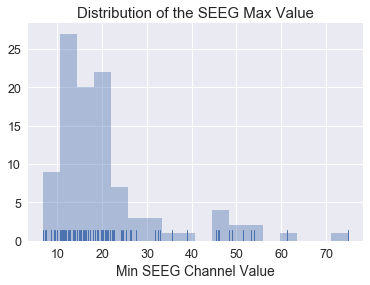

In [14]:
sigvals = []
for idx, sig in enumerate(seegts):
    sigvals.append(np.max(sig))

# print(sigvals)
    
fig = plt.figure()
sns.set(font_scale=1.25)
sns.distplot(np.multiply(sigvals,1), kde=False, rug=True,
             axlabel='Min SEEG Channel Value')
plt.title('Distribution of the SEEG Max Value')
ax = plt.gca()
# ax.set_xticks(np.arange(0,60,5))

# Apply Visualization of The Data

In [15]:
dist = -1
# filename = os.path.join(outputdatadir, 
#         patient+'_dist' + str(dist) + 'testall_longer.npz')
npfile = open(filename, 'r')
# save tseries
# np.savez_compressed(npfile, epits=epits, seegts=seegts, \
#          times=times, zts=zts, metadata=metadata)
data = np.load(npfile)
epits = data['epits']
seegts = data['seegts']
times = data['times']
zts = data['zts']
metadata = data['metadata'].item()

print(filename)
print(metadata.keys())
ezind = metadata['ezindices']
pzind = metadata['pzindices']
seizonsets = metadata['onsettimes']
seizoffsets = metadata['offsettimes']
region_labels = metadata['regions']
regions_centers = metadata['regions_centers']
chanlabels = metadata['chanlabels']
seeg_xyz = metadata['seeg_xyz']
ezreg = metadata['ez']
pzreg = metadata['pz']
ezind = metadata['ezindices']
pzind = metadata['pzindices']
epiparams = metadata['epiparams']

# get the onsettimes and offsettimes for ez/pz indices
# allindices = np.append(ezind, pzind, axis=0).astype(int)
# postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
# settimes = postprocessor.getonsetsoffsets(zts, allindices, lookahead=100, delta=0.2)# get the actual seizure times and offsets
# seizonsets, seizoffsets = postprocessor.getseiztimes(settimes, epsilon=0)

/Users/adam2392/Documents/pydata/tvbforwardsim/exp007/id008_gc_dist-1_testing.npz
['gainmat', 'x0norm', 'ez', 'pz', 'epiparams', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'offsettimes', 'x0pz', 'onsettimes', 'pzindices', 'patient', 'ezindices', 'chanlabels']


In [16]:
# metadata = {
#         'x0ez':x0ez,
#         'x0pz':x0pz,
#         'x0norm':x0norm,
#         'regions': region_labels,
#         'regions_centers': regions_centers,
#         'chanlabels': chanlabels,
#         'seeg_xyz': seeg_xyz,
#         'ez': ezreg,
#         'pz': pzreg,
#         'ezindices': ezind,
#         'pzindices': pzind,
#         'onsettimes':seizonsets,
#         'offsettimes':seizoffsets,
#         'patient':patient,
#         'epiparams': epiparams,
#     }

# # if dist != -1:
# filename = os.path.join(outputdatadir, 
#         patient+'_dist' + str(dist) + '_.npz')
# npfile = open(filename, 'wb')
# # save tseries
# np.savez_compressed(npfile, epits=epits, seegts=seegts, \
#          times=times, zts=zts, metadata=metadata)

In [17]:
# apply manual offsetting based on the epileptor source signals
# seizonsets[1] = seizonsets[1] + 100

print(settimes)
print(seizonsets)
print(seizoffsets)

[[ 6560. 14799.]
 [11125. 17547.]
 [14400. 24012.]
 [15604. 21440.]
 [29337. 36904.]
 [36068.    nan]
 [36447. 15393.]]
[6560.0, 29337.0]
[24012.0]


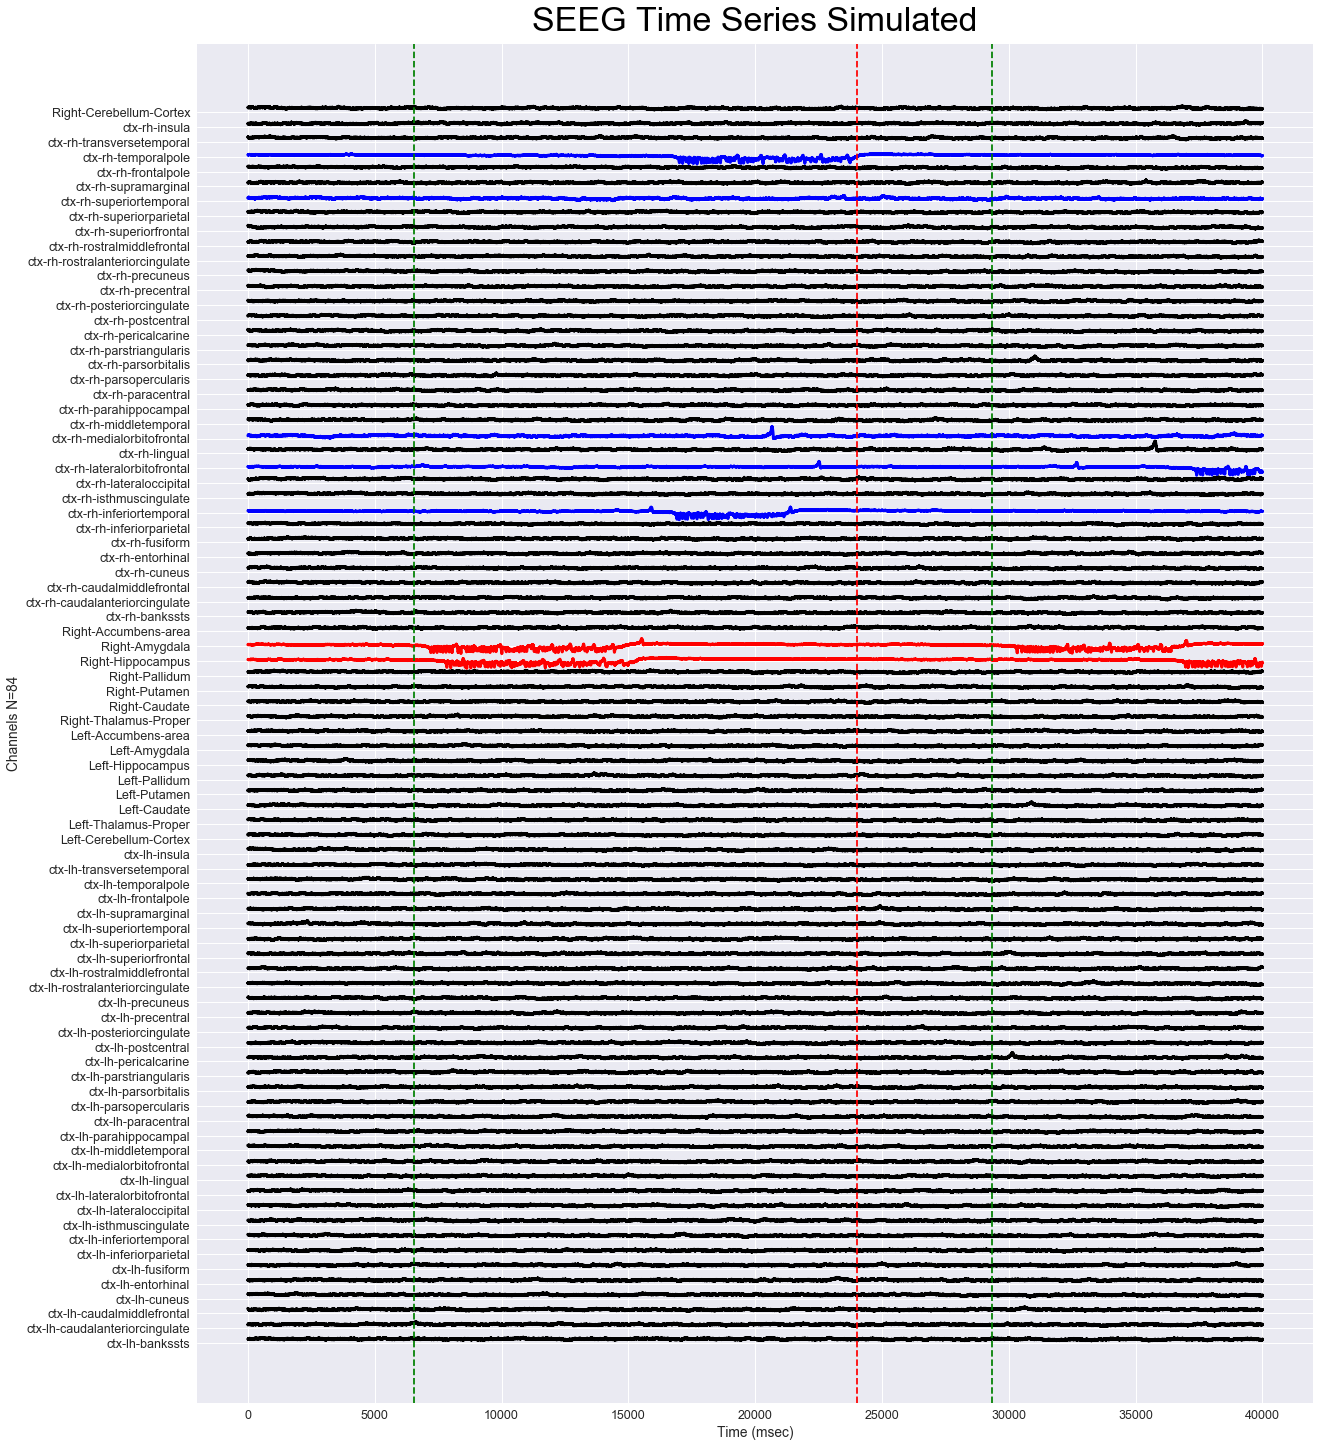

In [18]:
tsviz = tvbsim.visualize.plotts.VisualTs()
tsviz.loaddata(data=epits,ylabels=region_labels)
# visualize seegts
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True)
# tsviz.plotvertlines(onsettimes=settimes[:,0], offsettimes=settimes[:,1])
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
tsviz.colorts(ezind, color='red')
tsviz.colorts(pzind, color='blue')

In [48]:
brainplotter = tvbsim.visualize.plotbrain.VisualBrain()
brainplotter.setfigsize(figsize=(20,17))
brainplotter.loadsurf(maintvbexp.vertices)
brainplotter.loadseeg(maintvbexp.seeg_xyz, maintvbexp.seeg_labels)
brainplotter.loadregs(maintvbexp.conn.centres, maintvbexp.conn.region_labels)
brainplotter.setcontacts()

Nbre_contacts_per_electrode: [9, 6, 11, 9, 6, 9, 9]
Nbre_electrodes: 7
Ending Index of electrodes: [ 9 15 26 35 41 50 59]


id013_pg
num regions:  84
num contacts:  59
7
xreg:  (84,)
yreg:  (84,)
zreg:  (84,)


(<matplotlib.figure.Figure at 0x110bad690>,
 <matplotlib.axes._subplots.AxesSubplot at 0x111bceb10>)

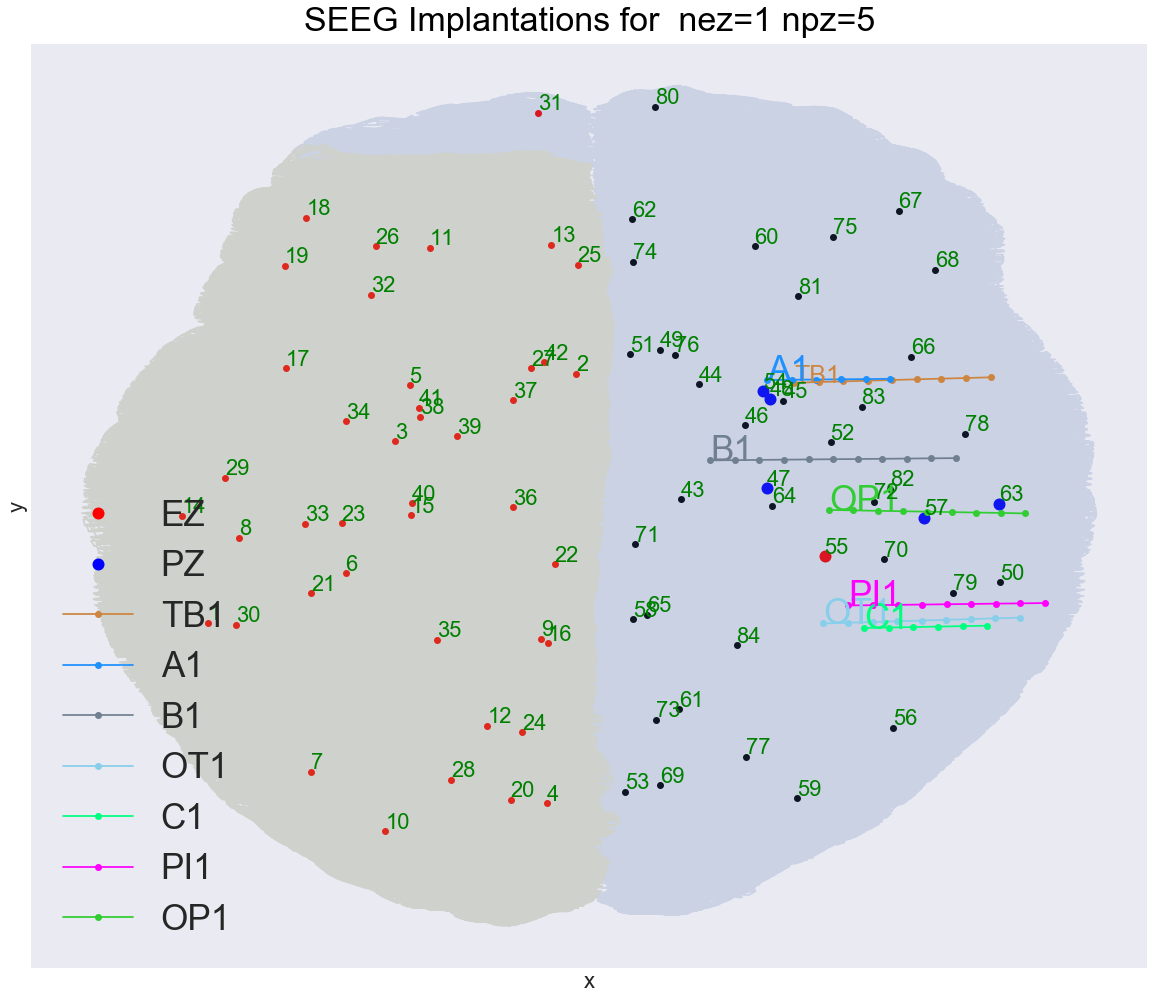

In [49]:
print(patient)
sns.set(font_scale=2.0)
brainplotter.plotcontactsinbrain(maintvbexp.ezind, maintvbexp.pzind)
#                                  titlestr='SEEG Implantation For ID001_PG (Success)')

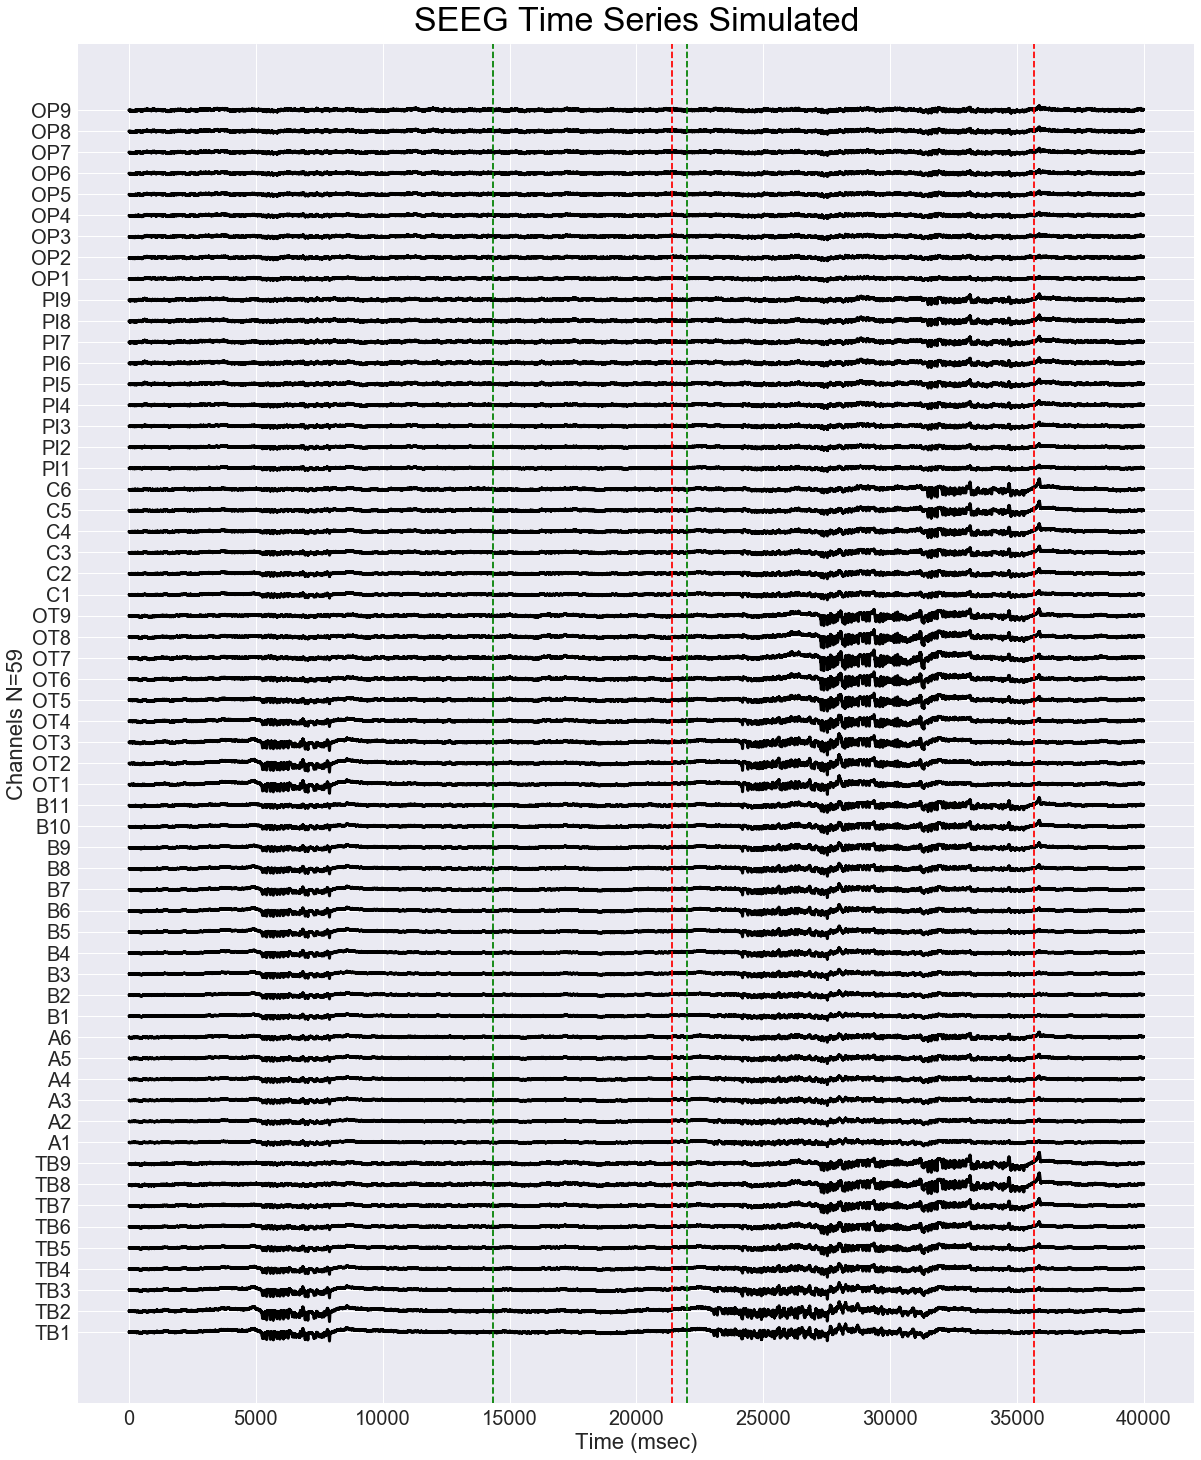

In [50]:
tsviz = tvbsim.visualize.plotts.VisualTs()
tsviz.loaddata(data=seegts,ylabels=maintvbexp.seeg_labels)
# visualize seegts
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True)
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
# tsviz.colorts(maintvbexp.ezind, color=colors[0])

[ 1693  3086  4315  8915 12711 14350 14863 17845 18187 22004 22739 24534
 26657 30745]
[ 3031 14934  8209 10404 14372 21425 16460 19284 21155 31796 27898 26227
 31580 35675]
0.6856652062733244
0.8569215225839462
0.8838645131242377
0.9418927602998064
1.1405521707130628
0.9824860274443465


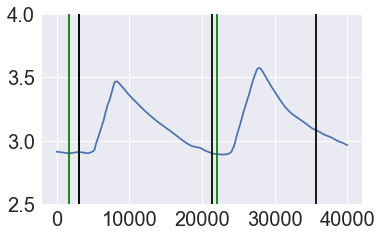

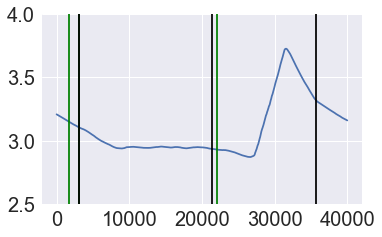

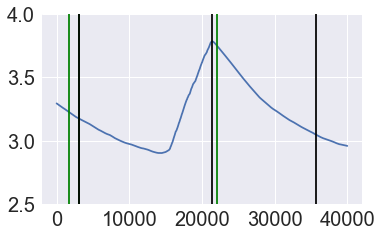

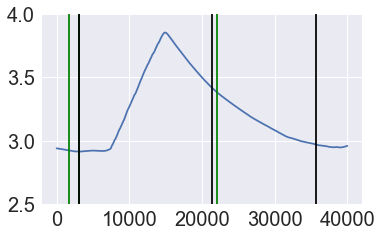

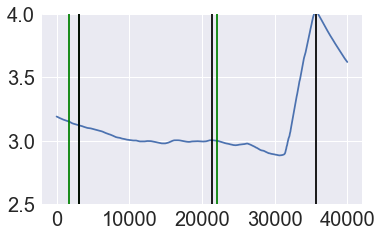

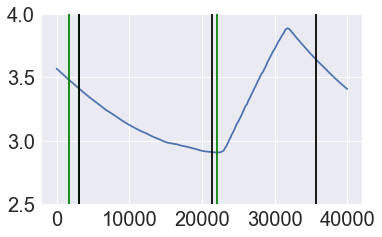

In [51]:
# get the onsettimes and offsettimes for ez/pz indices
allindices = np.append(ezind, pzind, axis=0).astype(int)
postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
settimes = postprocessor.getonsetsoffsets(zts, allindices, lookahead=100, delta=0.2/5)# get the actual seizure times and offsets
seizonsets, seizoffsets = postprocessor.getseiztimes(settimes, epsilon=0)

for ind in allindices:
    print(np.ptp(zts[ind,:]))
    plt.figure()
    plt.plot(zts[ind,:])
    for onset in seizonsets:
        plt.axvline(onset, color='green')
    for offset in seizoffsets:
        plt.axvline(offset, color='black')
    plt.ylim([2.5, 4.0])
    plt.tight_layout()

6.912231022526388e+17
(70, 70)


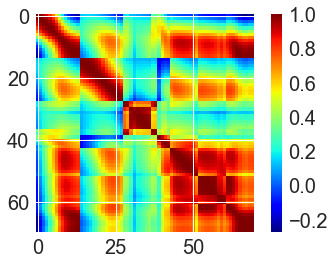

In [52]:
winsizems = 2500
corr = np.corrcoef(seegts[:, 0:winsizems])
# corr = np.cov(seegts[:, 0:winsizems])
print(np.linalg.cond(corr))
print(corr.shape)
plt.imshow(corr, cmap='jet')
plt.colorbar()

[[27527 28801]]
[[16709. 17306.]
 [17947. 18656.]
 [19794. 20534.]
 [21091. 21604.]
 [22097. 23159.]
 [52565.    nan]]
[[ 1170   452]
 [ 4244  2339]
 [ 5566  4911]
 [ 6853  6221]
 [ 7750  7453]
 [ 8647  8512]
 [10098  9860]
 [11661 11211]
 [20873 13046]
 [24750 20961]
 [27928 24774]
 [31839 28637]
 [32953 31893]
 [35296 33085]
 [37789 35424]
 [40320 38744]
 [43963 40442]
 [47088 44073]
 [51803 47340]
 [56904 52410]]
[[  757.   347.]
 [ 2383.  1707.]
 [ 3398.  2878.]
 [ 5461.  4549.]
 [ 7626.  7360.]
 [ 8821.  8656.]
 [14992. 14361.]
 [19391. 18508.]
 [20902. 19697.]
 [26496. 21285.]
 [40966. 27178.]
 [44670. 41109.]
 [47332. 44923.]
 [48785. 47934.]
 [52733. 49845.]
 [   nan 57548.]]
[[46840 49177]
 [51619 52770]]


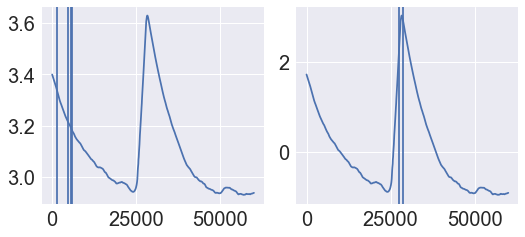

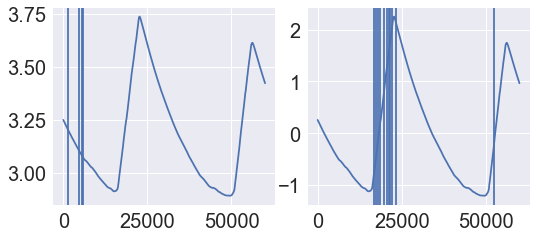

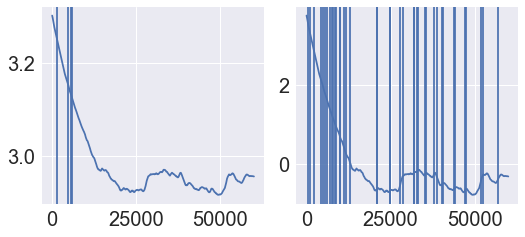

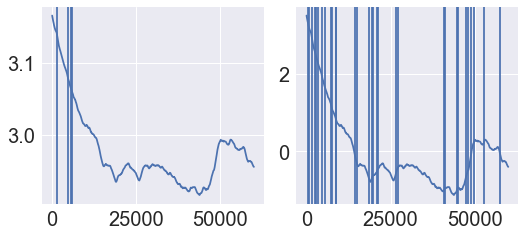

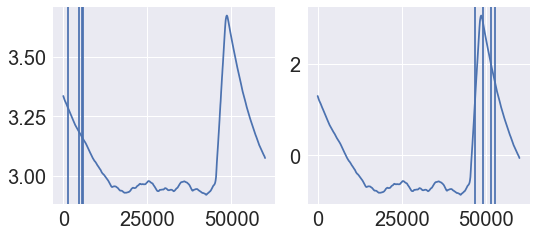

In [121]:
from sklearn.preprocessing import StandardScaler
# pzind = maintvbexp.pzind
# ezind = maintvbexp.ezind
scaler = StandardScaler()
tempzts = zts


for ind in pzind:
    plt.figure(figsize=(8,4))
    ''' PLOT THE SECOND PLOT WITH THE PROCESSED SIGNAL TO GET THE PEAKS '''
    plt.subplot(121)
    
    signal = zts[ind, :].squeeze()
#     diffzts = postprocessor.processz(signal)
    plt.plot(signal)
    settimes = postprocessor._findonsetoffset(diffzts,lookahead=100,delta=0.5)
    for i in settimes:
        try:
            plt.axvline(i[0])
            plt.axvline(i[1])
        except:
            print('not all onset/offset')
    plt.tight_layout()
    
    plt.subplot(122)
    allindices = [ind]
    postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
    settimes = postprocessor.getonsetsoffsets_new(zts, allindices, lookahead=10, delta=0.2)# get the actual seizure times and offsets
    signal = scaler.fit_transform(zts[ind,:].reshape(-1, 1))
#     minsig = np.min(signal.ravel())
#     signal[abs(signal) < abs(minsig*0.9)] = 0
    plt.plot(signal)
    for i in settimes:
        try:
            plt.axvline(i[0])
            plt.axvline(i[1])
        except:
            print('not all onset/offset')
#     print(settimes)
#     for i in settimes:
#         plt.axvline(i[0], color='green')
#         plt.axvline(i[1], color='red')
    
# for ind in ezind:
#     plt.figure(figsize=(8,4))
#     plt.subplot(121)
#     allindices = [ind]
#     postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
#     settimes = postprocessor.getonsetsoffsets(zts, allindices, lookahead=500, delta=1)# get the actual seizure times and offsets
#     plt.plot(scaler.fit_transform(zts[ind,:].reshape(-1, 1)))
#     print(settimes)
#     for i in settimes:
#         plt.axvline(i[0], color='green')
#         plt.axvline(i[1], color='red')
        
#     plt.subplot(122)
#     plt.plot(np.diff(tempzts[ind, :].squeeze(), n=2))
#     plt.tight_layout()


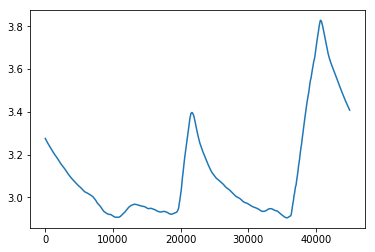

In [24]:
plt.plot(zts[pzind[0],:])

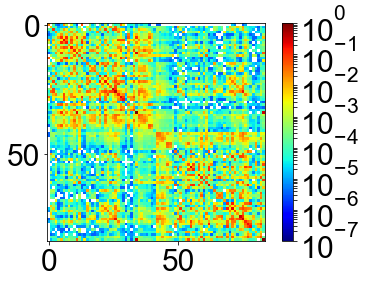

In [35]:
from matplotlib import colors, cm
plt.figure()
image = maintvbexp.conn.weights
norm = colors.LogNorm(1e-7, image.max()) #, clip='True')
plt.imshow(image, norm=norm, cmap=cm.jet)
plt.colorbar()
#max(con.weights[con.weights != 0])